<div class="alert alert-block alert-info">
<p style="font-size:24px;text-align:center"><b>Propagate a low-resolution hand-crafted laser pulse through a thin lens.</b>
<br>We initialize the laser pulse with a Gaussian intensity profile and a quadratic phase variation.
</div>

In [1]:
import array
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import os

from pykern.pkcollections import PKDict
# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    print("The rslaser library was not found; installing from GitHub...")
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser
from rslaser.optics import wavefront
from rslaser.optics import element
from rslaser.utils import merit_functions
from rslaser.pulse import pulse

import scipy
from scipy import constants, ndimage, stats
from scipy.ndimage.filters import gaussian_filter

# SRW and srwlib (the corresponding Python API) are pre-installed on Sirepo/Jupyter
import srwlib
from srwlib import srwl

In [2]:
# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

# Specify whether 2D and/or 3D plots should be rendered
RENDER_2D_PLOTS = True
RENDER_3D_PLOTS = False

# 3D plotting
if RENDER_3D_PLOTS:
    import plotly.graph_objects as go

In [3]:
def rms_calc_2d(_x, _y, f_dist):
    """
    Calculate the x and y averages and RMS of a 2d distribution f_dist(x,y)

    Args:
        _x, 2d numpy array that defines x values of the distribution
        _y, 2d numpy array that defines y values of the distribution
        f_dist, 2d numpy array that defines the x,y distribution
    
    Returns:
        x_avg, y_avg, the average values of x and y
        x_rms, y_rms, the RMS values of x and y

    Example:
        >>> xavg, yavg, xrms, yrms = rms_calc_2d(my_array)
    """
    x_f = np.multiply(_x, f_dist)
    y_f = np.multiply(_y, f_dist)
    sum_f = np.sum(f_dist)
    x_avg = np.sum(x_f) / sum_f
    y_avg = np.sum(y_f) / sum_f

    xsq_f = np.multiply(_x, x_f)
    ysq_f = np.multiply(_y, y_f)
    x_std = np.sum(xsq_f) / sum_f
    y_std = np.sum(ysq_f) / sum_f

    x_rms = math.sqrt(x_std - x_avg**2)
    y_rms = math.sqrt(y_std - y_avg**2)
    return x_avg, y_avg, x_rms, y_rms

In [4]:
# specify the mesh size
nx = 42
ny = 42

# create the x,y arrays with physical units based on the diagnostic pixel dimensions
x_max = 0.002    # [m]
x_min = -x_max
x1 = np.linspace(x_min, x_max, nx)

y_max = x_max
y_min = -y_max
y1 = np.linspace(y_min, y_max, ny)

x, y = np.meshgrid(x1, y1)

if False:
    print('x_min = ', np.min(x1))
    print('x_max = ', np.max(x1))
    print('x1.shape = ', x1.shape)

    print('y_min = ', np.min(y1))
    print('y_max = ', np.max(y1))
    print('y1.shape = ', y1.shape)

In [5]:
# create an idealized Gaussian distribution of intensities
x_rms = 0.25 * x_max
r_rms = x_rms * math.sqrt(2.)
intensity = merit_functions.gaussian_ccd(x, y, 0., 0., 1.45e11, r_rms)
print('intensity.shape = ', intensity.shape)

# pad with zeros
intensity[0:1,0:] = 0.
intensity[nx-2:,0:] = 0.
intensity[0:,0:1] = 0.
intensity[0:,nx-2] = 0.

# smooth the data
intensity = gaussian_filter(intensity, sigma=1)

print('intensity.shape = ', intensity.shape)

intensity.shape =  (42, 42)
intensity.shape =  (42, 42)


In [6]:
# Calculate intensity centroid and RMS values
xc, yc, xc_rms, yc_rms = rms_calc_2d(x, y, intensity)

print('xc = ', xc)
print('yc = ', yc)
print('xc_rms = ', xc_rms)
print('yc_rms = ', yc_rms)

xc =  -5.4878809454153444e-08
yc =  -1.0602633728547686e-07
xc_rms =  0.0005089635603825246
yc_rms =  0.0005088716976320129


In [7]:
def wfs_ideal(x, y, xc, yc, phi_max, r0):
    """Idealized wavefront sensor (WFS) data.

    Args:
        x, y (2d array): horizontal and vertical positions for the wavefront phase data
        xc, yc (float): approximate center of the laser pulse
        phi_max (float): maximum value of the wavefront phase
        r0 (float): defines quadratic behavior for r<r_mid

    Returns:
        function values (2d array):  phase values of complex E-field in an electromagnetic wavefront
    """
    # calculate radius r, as well as r**2
    rsq = (x-xc)**2 + (y-yc)**2
    r = np.sqrt(rsq)
    
    return phi_max * (1. + rsq/r0**2)

In [8]:
# create a phase distribution that works well with SRW
r0 =  0.001 # [m]
phi_max = -0.0025
phase = wfs_ideal(x, y, 0., 0., phi_max, r0)

# print(' phase = ', phase)

In [9]:
e_norm = np.sqrt(intensity)
ex_real = np.multiply(e_norm, np.cos(phase)).flatten(order='C')
ex_imag = np.multiply(e_norm, np.sin(phase)).flatten(order='C')

ex_numpy = np.zeros(2*len(ex_real))
for i in range(len(ex_real)):
    ex_numpy[2*i] = ex_real[i]
    ex_numpy[2*i+1] = ex_imag[i]

ex = array.array('f', ex_numpy.tolist())
ey = array.array('f', len(ex)*[0.])

In [10]:
wfr0 = srwlib.SRWLWfr(_arEx=ex, _arEy=ey, _typeE='f',
                    _eStart=1.55, _eFin=1.55, _ne=1,
                    _xStart=x_min, _xFin=x_max, _nx=nx,
                    _yStart=y_min, _yFin=y_max, _ny=ny,
                    _zStart=0., _partBeam=None)

Size of initial wavefront data array (coordinate): (42, 42)


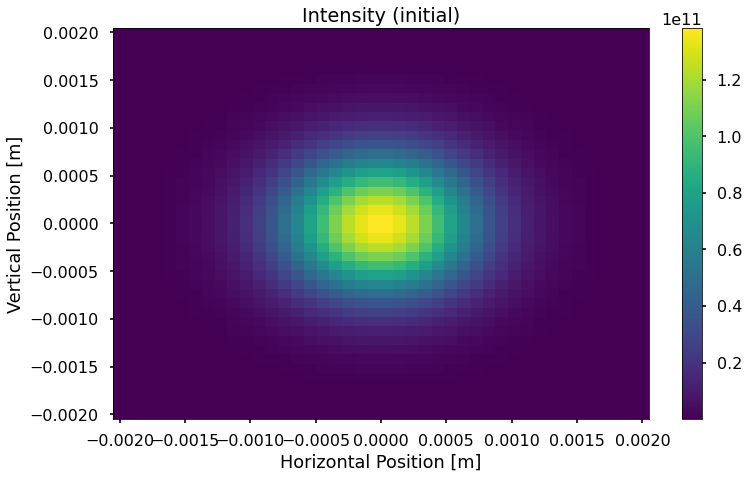

In [11]:
#Plot initial wavefront
##Initial wfr calculation
arIinit = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvalsf02=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x, y, arIinit2D, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [m]')
        ax.set_xlabel(r'Horizontal Position [m]')
        ax.set_title('Intensity (initial)')

In [12]:
# initial phase
phase0 = srwlib.array('d', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase0, wfr0, 0, 4, 3, wfr0.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_0 = np.array(phase0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsize=np.size(phase0)

print('Size of initial wavefront data array (coordinate):',np.shape(phase_2d_0))
x0=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
y0=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

Size of initial wavefront data array (coordinate): (42, 42)


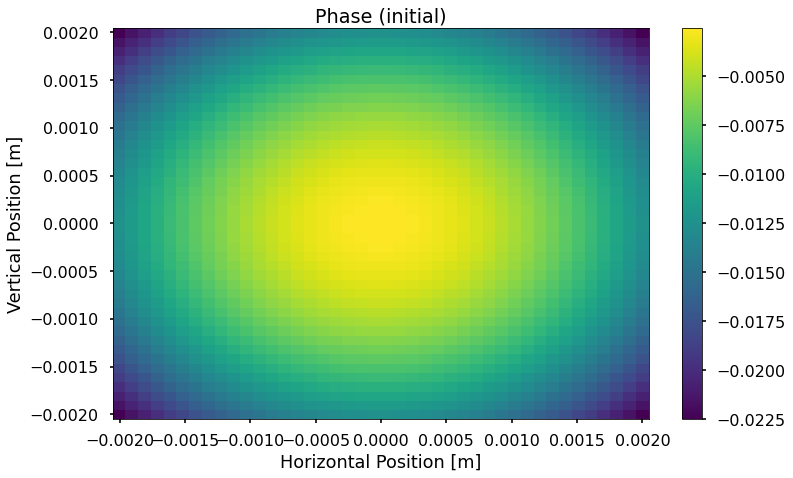

In [13]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x, y, phase_2d_0, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_xlabel(r'Horizontal Position [m]')
        ax.set_ylabel(r'Vertical Position [m]')
        ax.set_title('Phase (initial)')

In [14]:
# we need to know the wavefront centroid and rms properties
x_avg, y_avg, x_rms, y_rms = rms_calc_2d(x, y, arIinit2D)

print(' x_avg = {0:4.2e} [m]'.format(x_avg))
print(' y_avg = {0:4.2e} [m]'.format(y_avg))
print(' ')
print(' x_rms = {0:4.2e} [m]'.format(x_rms))
print(' y_rms = {0:4.2e} [m]'.format(y_rms))

wfr0.xc = x_avg       # transverse coordinate of wavefront "source center"
wfr0.yc = y_avg       # transverse coordinate of wavefront "source center"

wfr0.Rx = -r0          # wavefront radius
wfr0.Ry = -r0          # wavefront radius
# wfr0.Rx = -0.0099227          # wavefront radius
# wfr0.Ry = -0.0099227          # wavefront radius
wfr0.dRx = 0.
wfr0.dRy = 0.
# wfr0.dRx = 9.9227e-5
# wfr0.dRy = 9.9227e-5

wfr0.arMomX =  array.array('d', [840390541312.0, 7.364840065487388e-20, -1.4058507076697424e-05, 2.7263433550047373e-20, -1.4058507076697424e-05, 6.471726123891131e-07, -6.522995681734756e-05, 0.006574756931513548, 6.471726123891131e-07, -6.522995681734756e-05, 0.006574756931513548])
wfr0.arElecPropMatr =  array.array('d', [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0])

wfr0.avgPhotEn = 1.55    # average photon energy for time-domain simulations
wfr0.numTypeElFld =  b'f'

 x_avg = -5.49e-08 [m]
 y_avg = -1.06e-07 [m]
 
 x_rms = 5.09e-04 [m]
 y_rms = 5.09e-04 [m]


In [15]:
# create a laser pulse, using the wavefront created above

# photon energy corresponding to lambda = 1 micron
_LASER_PULSE_SLICE = PKDict(
    sigrW = math.sqrt(x_rms*y_rms),
    propLen = 15,
    pulseE = 0.001,
    poltype = 1,
    sampFact = 0.002,
    mx = 0,
    my = 0
)
_LASER_PULSE = PKDict(
        phE = 1.55,
        nslice = 1,
        chirp = 0,
        w0 = 2.*math.sqrt(x_rms*y_rms),
        a0 = .002,
        dw0x = 0.0,
        dw0y = 0.0,
        z_waist = -0.1,
        dzwx = 0.0,
        dzwy = 0.0,
        tau_fwhm = 0.1 / constants.c / math.sqrt(2.),
        z_center = 0.,
        x_shift = 0.,
        y_shift = 0.,
        d_to_w = 0.1,
        slice_params=_LASER_PULSE_SLICE,
)

In [16]:
# instantiate the laser pulse (this can take a few seconds)
in_pulse = PKDict(
    **_LASER_PULSE
    )
LP = pulse.LaserPulse(in_pulse)

slice=LP.slice
slice[0].wfr = wfr0

print(' nx = ', LP.slice[0].wfr.mesh.nx)
print(' ny = ', LP.slice[0].wfr.mesh.ny)
print(' ne = ', LP.slice[0].wfr.mesh.ne)
print(' ')
print(' xStart = ', LP.slice[0].wfr.mesh.xStart)
print(' xFin = ', LP.slice[0].wfr.mesh.xFin)
print(' yStart = ', LP.slice[0].wfr.mesh.yStart)
print(' yFin = ', LP.slice[0].wfr.mesh.yFin)
print(' eStart = ', LP.slice[0].wfr.mesh.eStart)
print(' eFin = ', LP.slice[0].wfr.mesh.eFin)
print(' zStart = ', LP.slice[0].wfr.mesh.zStart)
print(' ')
print(' nvx = ', LP.slice[0].wfr.mesh.nvx)
print(' nvy = ', LP.slice[0].wfr.mesh.nvy)
print(' nvz = ', LP.slice[0].wfr.mesh.nvz)
print(' hvx = ', LP.slice[0].wfr.mesh.hvx)
print(' hvy = ', LP.slice[0].wfr.mesh.hvy)
print(' hvz = ', LP.slice[0].wfr.mesh.hvz)
print(' arSurf = ', LP.slice[0].wfr.mesh.arSurf)
print(' ')
print(' avgPhotEn = ', LP.slice[0].wfr.avgPhotEn)
print(' presCA = ', LP.slice[0].wfr.presCA)
print(' presFT = ', LP.slice[0].wfr.presFT)
print(' unitElFld = ', LP.slice[0].wfr.unitElFld)
print(' unitElFldAng = ', LP.slice[0].wfr.unitElFldAng)
print(' ')
print(' Rx = ', LP.slice[0].wfr.Rx)
print(' Ry = ', LP.slice[0].wfr.Ry)
print(' dRx = ', LP.slice[0].wfr.dRx)
print(' dRy = ', LP.slice[0].wfr.dRy)
print(' xc = ', LP.slice[0].wfr.xc)
print(' yc = ', LP.slice[0].wfr.yc)
print(' ')
print(' numTypeElFld = ', LP.slice[0].wfr.numTypeElFld)
print(' partBeam = ', LP.slice[0].wfr.partBeam)
print(' arElecPropMatr = ', LP.slice[0].wfr.arElecPropMatr)
print(' arMomX = ', LP.slice[0].wfr.arMomX)
print(' arMomY = ', LP.slice[0].wfr.arMomY)
print(' arWfrAuxData = ', LP.slice[0].wfr.arWfrAuxData)

 nx =  42
 ny =  42
 ne =  1
 
 xStart =  -0.002
 xFin =  0.002
 yStart =  -0.002
 yFin =  0.002
 eStart =  1.55
 eFin =  1.55
 zStart =  0.0
 
 nvx =  0
 nvy =  0
 nvz =  1
 hvx =  1
 hvy =  0
 hvz =  0
 arSurf =  None
 
 avgPhotEn =  1.55
 presCA =  0
 presFT =  0
 unitElFld =  1
 unitElFldAng =  0
 
 Rx =  -0.001
 Ry =  -0.001
 dRx =  0.0
 dRy =  0.0
 xc =  -5.4878784698846375e-08
 yc =  -1.060263423475905e-07
 
 numTypeElFld =  b'f'
 partBeam =  <srwlib.SRWLPartBeam object at 0x7faeae86dcc0>
 arElecPropMatr =  array('d', [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0])
 arMomX =  array('d', [840390541312.0, 7.364840065487388e-20, -1.4058507076697424e-05, 2.7263433550047373e-20, -1.4058507076697424e-05, 6.471726123891131e-07, -6.522995681734756e-05, 0.006574756931513548, 6.471726123891131e-07, -6.522995681734756e-05, 0.006574756931513548])
 arMomY =  array('d', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 arWfrAuxData

In [17]:
# look at the horizontal electric field
print(' min(wfr0.arEx) = ', np.min(wfr0.arEx))
print(' max(wfr0.arEx) = ', np.max(wfr0.arEx))

 min(wfr0.arEx) =  -934.9858
 max(wfr0.arEx) =  372030.22


<div class="alert alert-block alert-info">
<p style="font-size:18px;">Create a simple focusing lens and propagate the laser pulse.</p>
</div>

In [18]:
# instantiate a simple focusing lens
focal_length = 1.   # [m]
lattice_lens = [(element.Lens(focal_length),'default')]

# propagate the pulse through the lattice
for iterator in lattice_lens:
    current_elem, prop_type = iterator
    LP = current_elem.propagate(LP, prop_type)

In [19]:
# transmitted pulse - intensity
wfr2=LP.slice[0].wfr

intensity2 = srwlib.array('f', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity2, wfr2, 0, 0, 3, wfr2.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intens_2d_2 = np.array(intensity2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')
wfrsizei=np.size(intensity2)

print('Size of initial wavefront data array (coordinate):',np.shape(intens_2d_2))
x2=np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
y2=np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)

Size of initial wavefront data array (coordinate): (42, 42)


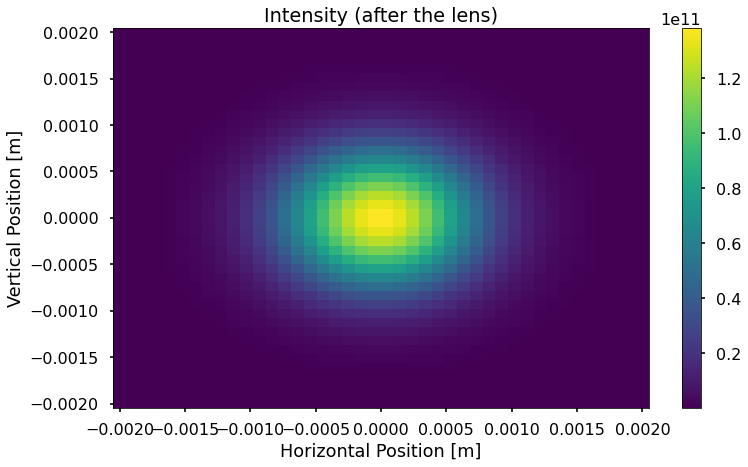

In [20]:
# plot the computed intensity
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(x, y, intens_2d_2, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [m]')
        ax.set_xlabel(r'Horizontal Position [m]')
        ax.set_title('Intensity (after the lens)')

In [21]:
# transmitted pulse - phase
phase2 = srwlib.array('d', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase2, wfr2, 0, 4, 3, wfr2.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_2 = np.array(phase2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')
wfrsize=np.size(phase2)

print('Size of initial wavefront data array (coordinate):',np.shape(phase_2d_2))
x2=np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
y2=np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)

# print(' ')
# print(' phase_2d_2 = ', phase_2d_2)

Size of initial wavefront data array (coordinate): (42, 42)


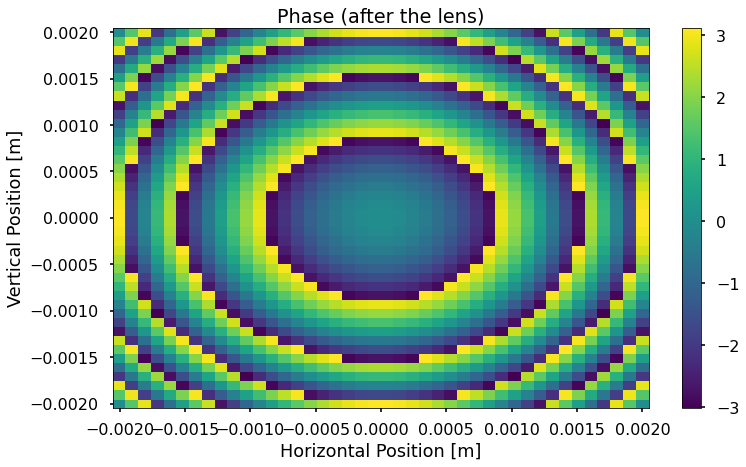

In [22]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(x, y, phase_2d_2, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [m]')
        ax.set_xlabel(r'Horizontal Position [m]')
        ax.set_title('Phase (after the lens)')

In [23]:
print(' nx = ', LP.slice[0].wfr.mesh.nx)
print(' ny = ', LP.slice[0].wfr.mesh.ny)
print(' ne = ', LP.slice[0].wfr.mesh.ne)
print(' ')
print(' xStart = ', LP.slice[0].wfr.mesh.xStart)
print(' xFin = ', LP.slice[0].wfr.mesh.xFin)
print(' yStart = ', LP.slice[0].wfr.mesh.yStart)
print(' yFin = ', LP.slice[0].wfr.mesh.yFin)
print(' eStart = ', LP.slice[0].wfr.mesh.eStart)
print(' eFin = ', LP.slice[0].wfr.mesh.eFin)
print(' zStart = ', LP.slice[0].wfr.mesh.zStart)
print(' ')
print(' nvx = ', LP.slice[0].wfr.mesh.nvx)
print(' nvy = ', LP.slice[0].wfr.mesh.nvy)
print(' nvz = ', LP.slice[0].wfr.mesh.nvz)
print(' hvx = ', LP.slice[0].wfr.mesh.hvx)
print(' hvy = ', LP.slice[0].wfr.mesh.hvy)
print(' hvz = ', LP.slice[0].wfr.mesh.hvz)
print(' arSurf = ', LP.slice[0].wfr.mesh.arSurf)
print(' ')
print(' avgPhotEn = ', LP.slice[0].wfr.avgPhotEn)
print(' presCA = ', LP.slice[0].wfr.presCA)
print(' presFT = ', LP.slice[0].wfr.presFT)
print(' unitElFld = ', LP.slice[0].wfr.unitElFld)
print(' unitElFldAng = ', LP.slice[0].wfr.unitElFldAng)
print(' ')
print(' Rx = ', LP.slice[0].wfr.Rx)
print(' Ry = ', LP.slice[0].wfr.Ry)
print(' dRx = ', LP.slice[0].wfr.dRx)
print(' dRy = ', LP.slice[0].wfr.dRy)
print(' xc = ', LP.slice[0].wfr.xc)
print(' yc = ', LP.slice[0].wfr.yc)
print(' ')
print(' numTypeElFld = ', LP.slice[0].wfr.numTypeElFld)
print(' partBeam = ', LP.slice[0].wfr.partBeam)
print(' arElecPropMatr = ', LP.slice[0].wfr.arElecPropMatr)
print(' arMomX = ', LP.slice[0].wfr.arMomX)
print(' arMomY = ', LP.slice[0].wfr.arMomY)
print(' arWfrAuxData = ', LP.slice[0].wfr.arWfrAuxData)

 nx =  42
 ny =  42
 ne =  1
 
 xStart =  -0.002
 xFin =  0.002
 yStart =  -0.002
 yFin =  0.002
 eStart =  1.55
 eFin =  1.55
 zStart =  0.0
 
 nvx =  0
 nvy =  0
 nvz =  1
 hvx =  1
 hvy =  0
 hvz =  0
 arSurf =  None
 
 avgPhotEn =  1.55
 presCA =  0
 presFT =  0
 unitElFld =  1
 unitElFldAng =  0
 
 Rx =  -0.0009990009990009992
 Ry =  -0.0009990009990009992
 dRx =  9.990009990009993e-05
 dRy =  9.990009990009993e-05
 xc =  -5.482396073810827e-08
 yc =  -1.0592042192566485e-07
 
 numTypeElFld =  b'f'
 partBeam =  <srwlib.SRWLPartBeam object at 0x7faeae86dcc0>
 arElecPropMatr =  array('d', [1.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0])
 arMomX =  array('d', [840390541312.0, 7.364840065487388e-20, -1.4058507076697497e-05, 2.7263433550047373e-20, -1.4058507076697451e-05, 6.471726123891131e-07, -6.587712942973667e-05, 0.006705864017760632, 6.471726123891131e-07, -6.587712942973667e-05, 0.006705864017760632])
 arMomY =  array('d', 

In [24]:
# look at the horizontal electric field
print(' min(wfr2.arEx) = ', np.min(wfr2.arEx))
print(' max(wfr2.arEx) = ', np.max(wfr2.arEx))

 min(wfr2.arEx) =  -261949.17
 max(wfr2.arEx) =  371947.75
